<a href="https://colab.research.google.com/github/ExpertsVision/Hobby/blob/master/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:

# Import Packages
from google.colab import drive
import numpy as np
import scipy.io
import pandas as pd
from datetime import datetime, timedelta
import os
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.models import model_from_json
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from os import listdir
from glob import glob
import math
import shutil
import re
import pathlib

In [33]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import cv2
from imutils import paths  
import numpy as np
import os, errno

# **Downloading IMDB Dataset from Google Drive link**

We are using Google drive sharable link from https://drive.google.com/uc?id=1-7vXBlCordEUBxZanZPWYXnfPpW-lzIV&export=download
You can also download this file directly from original link i.e. https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

In [ ]:
!gdown --id 1-7vXBlCordEUBxZanZPWYXnfPpW-lzIV&export=download

Downloading...
From: https://drive.google.com/uc?id=1-7vXBlCordEUBxZanZPWYXnfPpW-lzIV
To: /content/imdb_crop.tar
7.01GB [02:26, 48.0MB/s]


# **Processing of data**


We need to unzip the tar code so we unzipped it as imdb_crop






In [ ]:
#Unzip imdb_crop.tar
!tar -xf imdb_crop.tar

In [ ]:
mat = scipy.io.loadmat('/content/imdb_crop/imdb.mat')


## Mounting Google drive

Now we are attaching our Google drive so processed images will be saved in our google drive. We won't need all these steps for face cropping and will be able to use cropped faces data in different projects.

In [34]:

from google.colab import drive 
drive.mount('/content/gdrive') 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
try:
  instances = mat['imdb'][0][0][0].shape[1]
  
  columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
  
  df = pd.DataFrame(index = range(0,instances), columns = columns)
  
  for i in mat:
    if i == "imdb":
      current_array = mat[i][0][0]
      for j in range(len(current_array)):
        df[columns[j]] = pd.DataFrame(current_array[j][0])
except:
  pass

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN


In [ ]:
df.describe()

,dob,photo_taken,gender,face_score,second_face_score
count,460723.000000,460723.000000,452261.000000,4.607230e+05,213797.000000
mean,718987.731774,2005.461555,0.581996,-inf,2.452904
std,13253.963535,9.054475,0.493231,NaN,1.064432
min,47.000000,1961.000000,0.000000,-inf,0.730926
25%,716370.000000,2004.000000,0.000000,1.757891e+00,1.583692
50%,719935.000000,2008.000000,1.000000,2.980097e+00,2.355163
75%,723073.000000,2011.000000,1.000000,4.006376e+00,3.228071
max,734963.000000,2015.000000,1.000000,7.381689e+00,6.395435


In [ ]:
df.tail()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN
460719,726831,2011,[08/nm3994408_rm784182528_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 426, 640]]",-inf,NaN
460720,726831,2011,[08/nm3994408_rm926592512_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 453, 640]]",-inf,NaN
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN
460722,726831,2011,[08/nm3994408_rm976924160_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[457.524, 41.748, 518.016, 102.24]]",2.133503,NaN


In [ ]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
df.describe()

,dob,photo_taken,gender,face_score,second_face_score
count,398421.000000,398421.000000,391197.000000,398421.000000,213797.000000
mean,718924.008915,2005.430873,0.572279,3.243474,2.452904
std,13177.362305,9.083973,0.494749,1.222315,1.064432
min,47.000000,1961.000000,0.000000,0.730919,0.730926
25%,716333.000000,2004.000000,0.000000,2.325559,1.583692
50%,719863.000000,2008.000000,1.000000,3.254706,2.355163
75%,722991.000000,2011.000000,1.000000,4.160408,3.228071
max,734181.000000,2015.000000,1.000000,7.381689,6.395435


In [ ]:
# Only consider images in which there is no 2nd face, i.e second_face_score is nan
df = df[df['second_face_score'].isna()]
df.describe()

,dob,photo_taken,gender,face_score,second_face_score
count,184624.000000,184624.000000,181690.000000,184624.000000,0.0
mean,719075.218785,2005.815322,0.550399,3.094982,NaN
std,13659.317612,8.515250,0.497455,1.362412,NaN
min,75.000000,1961.000000,0.000000,0.730919,NaN
25%,716509.000000,2004.000000,0.000000,1.960643,NaN
50%,720002.000000,2008.000000,1.000000,3.067435,NaN
75%,723097.000000,2011.000000,1.000000,4.175454,NaN
max,734181.000000,2015.000000,1.000000,7.381689,NaN


In [ ]:
# Only select pictures where face_score >3
df = df[df['face_score'] >= 3]
df.describe()

,dob,photo_taken,gender,face_score,second_face_score
count,95234.000000,95234.000000,93526.000000,95234.000000,0.0
mean,719600.493794,2006.359504,0.485961,4.213789,NaN
std,12963.520343,7.696399,0.499806,0.782275,NaN
min,75.000000,1961.000000,0.000000,3.000004,NaN
25%,717169.750000,2004.000000,0.000000,3.556245,NaN
50%,720426.000000,2008.000000,0.000000,4.137897,NaN
75%,723383.000000,2011.000000,1.000000,4.787703,NaN
max,733282.000000,2015.000000,1.000000,7.381689,NaN


**Copying filtered images in another folder**
I am copying all filtered images in my Google drive so I don't have to run all above processing steps everytime. I will just mount my google drive with colab notebook and will use this filter_dataset folder for further processing. 

In [11]:

my_directory = '/content/gdrive/My Drive/filtered_dataset/'
our_path = pathlib.Path(my_directory)
    

if our_path.exists ():
    pass
else:
    os.makedirs(my_directory)
    for i in range(df.shape[0]):
      image_path = '/content/imdb_crop/%s'%df.iloc[i,2][0]
      # Here we are only taking path of images whose names are in our fitlered df
      shutil.copy(image_path, my_directory)  # copying filtered images to directory

  



**Face Cropping using MTCNN**

In [35]:
pip install mtcnn


In [37]:
detector=MTCNN()

In [77]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
	# show the plot
	pyplot.show()

In [78]:
file_names_list=list(paths.list_images(my_directory)) #path of images folder
cropped_images = '/content/gdrive/My Drive/cropped_dataset/'

try:
         os.makedirs(cropped_images)

except OSError as e:
    if e.errno!=errno.EEXIST:
        raise

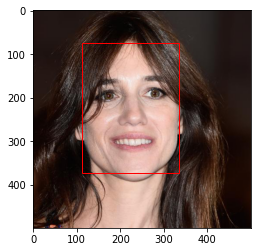

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001250_rm2001913344_1971-7-21_2011crop1.jpg
image written successfully


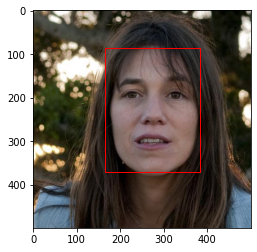

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001250_rm2305408512_1971-7-21_2010crop2.jpg
image written successfully


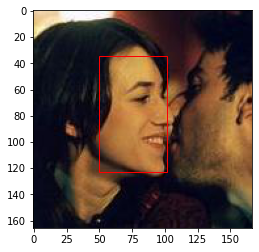

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001250_rm4125858048_1971-7-21_2001crop3.jpg
image written successfully


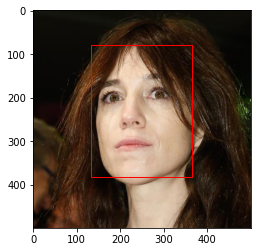

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001250_rm972222976_1971-7-21_2015crop4.jpg
image written successfully


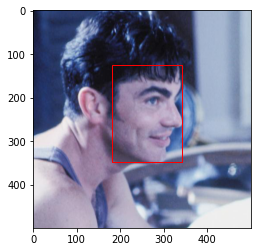

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001251_rm1058439168_1955-8-19_1993crop5.jpg
image written successfully


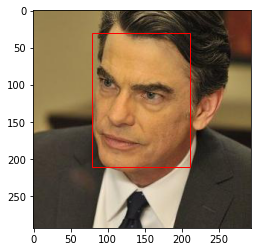

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001251_rm144812032_1955-8-19_2010crop6.jpg
image written successfully


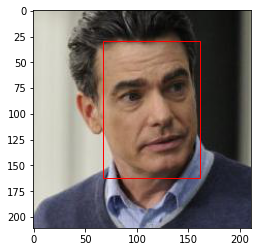

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001251_rm1668186112_1955-8-19_2010crop7.jpg
image written successfully


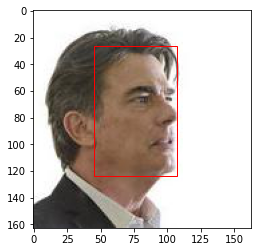

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001251_rm174841344_1955-8-19_2010crop8.jpg
image written successfully


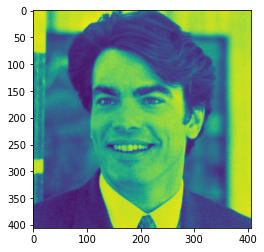

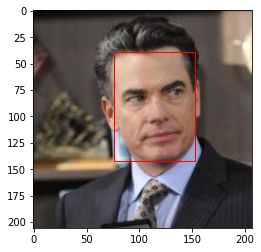

path to write cropped image is:  /content/gdrive/My Drive/cropped_dataset/nm0001251_rm2052161792_1955-8-19_2010crop9.jpg
image written successfully


In [79]:


count=0
#limit=10 
limit=len(file_names_list)
"""You can uncomment limit=10 to select only 10 images to see the results quickly. """


for index, filename in zip(range(limit), file_names_list):
    #print(filename)  # You can see absolute image names by uncommenting this line
    img = pyplot.imread(filename)
    image_name=filename.split(os.path.sep)[-1].split(".")[0] # This image name will be used for cropped folder
    if len(img.shape)==2:  # It will convert 2D image into RGB image which is needed for our algorithm. 
        pixels=np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)
    else:
        pixels=np.array(img)

    count=count+1
    print ('counter value is: ', count)

        
    pathwrite=(cropped_images+image_name+'crop'+str(count)+'.jpg')
    pathwrite_check=pathlib.Path(pathwrite)
    
    #  This code is useful for larger datasets where system gets disconnected during images cropping and copying process.
    # Using this code, images which were already cropped and saved will not be processed in next run. 

    if pathwrite_check.exists ():  
        pass
    
    else:
        faces = detector.detect_faces(pixels)
        #draw_image_with_boxes(filename, faces) # uncomment it if you want to display images
        if faces!=[]:
            x1, y1, width, height = faces[0]['box']
            x2, y2 = x1 + width, y1 + height  
            # # extract face
            face = img[y1:y2, x1:x2]
            

        """ We are renaming image names by appending crop string at end of their 
        original names so we could cross check our cropping resulrs """
        
        #print ('path to write cropped image is: ', pathwrite)


        try:
            cv2.imwrite(pathwrite,face)
            print ('image written successfully')


        except:
            print ('image written successfully')
            pass

Faces is a list for each image which will have different parameters like bounding box coordinates, confidence, moutg, eyes, and nose coordinates.

In [54]:
faces

[{'box': [76, 39, 77, 103],
  'confidence': 0.9998356103897095,
  'keypoints': {'left_eye': (97, 83),
   'mouth_left': (104, 121),
   'mouth_right': (137, 116),
   'nose': (118, 101),
   'right_eye': (134, 78)}}]